In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# path where the data is contained
path = '/content/drive/MyDrive/IHLT/lab2/'

import pandas as pd
import re
import nltk
from nltk import ne_chunk
from nltk.metrics import jaccard_distance
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from scipy.stats import pearsonr
from IPython.display import display_html 


import nltk
nltk.download('maxent_ne_chunker')
nltk.download('conll2000')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('words')

In [ ]:
# read the dataset and apply the lesk function for each pair of sentences
def data_reader(function_preprocess):
  dt = pd.read_csv(path + 'STS.input.SMTeuroparl.txt', sep='\t', header = None) # i guess we could read this just once but eh
  dt[2] = dt.apply(lambda row: function_preprocess(row[0]), axis = 1)
  dt[3] = dt.apply(lambda row: function_preprocess(row[1]), axis = 1)
  dt['gs'] = pd.read_csv(path + 'STS.gs.SMTeuroparl.txt', sep='\t', header = None)
  dt['jac'] = dt.apply(lambda row: 5*(1 - jaccard_distance(row[2], row[3])), axis = 1)
  #dt.drop_duplicates(subset = [0, 1], keep=False, inplace = True) # drop duplicate rows, but no one seems to be doing it so why should we 
  return dt

# Lab 7: Word Sequences

For the seventh practical of the subject, the goal is to get in touch with Word Sequences and ust NERC models. The statement is as follows:

1. Read all pairs of sentences of the SMTeuroparl files of test set within the evaluation framework of the project.
2. Compute their Jaccard similarities by considering the words plus the named entities.
3. Show the results and answer: "Do you think it could be relevant to use NEs to compute the similarity between two sentences?" 
4. Optional exercise: given a grammar enlarge it to parse it as they say



In [ ]:
stopw = set(nltk.corpus.stopwords.words('english')) # english stopwords

def NE_basic(sentence):
  tokens = nltk.word_tokenize(sentence) # tokenize
  pairs = nltk.pos_tag(tokens) # get the pos of the tokens
  chunks = nltk.ne_chunk(pairs, binary = False) # chunk it # https://www.youtube.com/watch?v=zDnPFxnALBg
  triads = nltk.tree2conlltags(chunks) # get the triads with the token, pos tag, and if its named entity
  text = []
  for triad in triads:
    token = re.sub(r'[^\w\s]', '', triad[0]).lower() # remove punctuaction inside each token
    if token in stopw or re.match(r'^[_\W]+$', token) or token == '': # if its stopword, non-alphanumeric token, or empty we skip
      continue
    if triad[2][0] == 'O': # if not named enitity we append to text
      text.append(token)
    elif triad[2][0] == 'B': # if named entity we append to text as well
      text.append(token)
    else: # if the named entity continues, we concatanate it with the last string
      text[-1] += ' ' + token
  return set(text)

In [ ]:
dt = data_reader(NE_basic)

Let us check some concrete examples where the NE worked. In the following output, we can see how `European` and `Union` got correctly joined to form `European Union`. While this makes sense in a human standpoint, in the case of our score, it actually returns a worse result. This is due that we are only checking the intersection of the elements, hence, since we have one less word that will be matched, we get a worse result. Since we now only have one word in the set that matches, the score is $5\frac{1}{4 + 5 - 1} = 0.625$, while if we had the set with `european` and `union` separated we would get $5\frac{2}{5 + 6 - 2} = 1.11$, which is closer to the gold standard.

Additionally, on the first sentence pair, we can see that since `report` appears in uppercase in the first sentence and lowercase on the second, it will change the named entity detection. This little change makes it not be detected as a named entity on the second pair. Observing the chunking output:

1. `('Van', 'NNP', 'B-PERSON'), ('Orden', 'NNP', 'B-PERSON'), ('Report', 'NNP', 'I-PERSON')`

2. `('Van', 'NNP', 'B-PERSON'), ('Orden', 'NNP', 'B-ORGANIZATION'), ('report', 'NN', 'O')`

Moreover, we can see how `Van` and `Orden` are detected both as beginnings of NE in both sentences. Hence, this is the reason we do not join `Van` with `Orden Report`.

Finally, the Pearson correlation returns lower than the second practical.

In [ ]:
styler = dt.iloc[[373, 374]].style.set_table_attributes("style='display:inline'")
display_html(styler._repr_html_(), raw=True)

,0,1,2,3,gs,jac
373,Van Orden Report (A5-0241/2000),Van Orden report (A5-0241 / 2000),"{'van', 'a502412000', 'orden report'}","{'a50241', '2000', 'orden', 'van', 'report'}",5.000000,0.714286
374,The European Union has got to do something and do it quickly.,It suits that the European Union is implied and that it makesit rapidly.,"{'quickly', 'something', 'european union', 'got'}","{'makesit', 'suits', 'european union', 'implied', 'rapidly'}",3.000000,0.625000


In [ ]:
pearsonr(dt['gs'], dt['jac'])[0]

0.4479641166806418

## With Spacy

In [ ]:
import spacy
nlp = spacy.load("en_core_web_sm")

In [ ]:
def NE_spacy(sentence, print = False):
  tokens = nlp(sentence) # why is spacy so much simpler 
  text = []
  if print:
    spacy.displacy.render(tokens, jupyter = True, style='ent')
  with tokens.retokenize() as retokenizer:
    token = [t for t in tokens]
    for ent in tokens.ents:
        retokenizer.merge(tokens[ent.start:ent.end], 
                          attrs={"LEMMA": " ".join([tokens[i].text for i in range(ent.start, ent.end)])})
  
  text = []
  for token in tokens:
    token = re.sub(r'[^\w\s]', '', token.text).lower() # remove punctuaction inside each token
    if token in stopw or re.match(r'^[_\W]+$', token) or token == '': # if its stopword, non-alphanumeric token, or empty we skip
      continue
    text.append(token)
  return set(text)

In [ ]:
dt = data_reader(NE_spacy)

In [ ]:
styler = dt.iloc[[373, 374]].style.set_table_attributes("style='display:inline'")
display_html(styler._repr_html_(), raw=True)

,0,1,2,3,gs,jac
373,Van Orden Report (A5-0241/2000),Van Orden report (A5-0241 / 2000),"{'a502412000', 'van orden report'}","{'report', 'a50241 2000', 'van orden'}",5.000000,0.000000
374,The European Union has got to do something and do it quickly.,It suits that the European Union is implied and that it makesit rapidly.,"{'quickly', 'the european union', 'got', 'something'}","{'makesit', 'suits', 'the european union', 'implied', 'rapidly'}",3.000000,0.625000


In [ ]:
print('First sentence')
_ = dt.iloc[[373, 374]].apply(lambda row: NE_spacy(row[0], True), axis = 1)
print('Second sentence')
_ = dt.iloc[[373, 374]].apply(lambda row: NE_spacy(row[1], True), axis = 1)

First sentence


Second sentence


In [ ]:
pearsonr(dt['gs'], dt['jac'])[0]

0.4399393862466662

We do not obtain much better correlation, and we can see how now it joined even more words. Which can be good or bad, and it seems worse for the paraphrase detection. Moreover, since we have not removed the stopwords, it joined `The` with `European Union`, which we could probably avoid if we first remove stopwords. However, if we first remove stopwords the POS tags might not work properly, and the chunking might not work properly, since they might depend on them to correctly infer the context.

Moreover, we see that `a50241/2000` got detected as different things, cardinal or date depending on if there is a space in between the `/` or not. However, our match fails since we removed all the symbols inside tokens, and there appears a space on the second pair due to the fact that it joined `a50241` and `2000`. We could fix this by removing all white spaces inside joined tokens, but then all NE would be joined and look ugly. Additionally, while it might work well in this case, there might be some edge case where it does not as expected. We will have to deal with these problems for the last practical, this was more to see how Spacy worked than have a perfect implementation.



# Conclusion


Comparing the results with the simple preprocessing we did in Lab 2 (not taking into consideration the NE, removing stopwords, symbols, etc.), we can see that we obtain a worse result than just using the tokens.

We can attribute this to two different reasons. First, using NE, we will join words together, and in some cases the resulting positive matches from the intersection will be lower than having them seperate and thus, returns a lower score, which we have seen in the `European Union` case. Secondly, the concatenation of these words is not working perfectly, as we have seen in the `Van Ordern Report` case. Which the three words sometimes are joined into different subsets, depending on if `report` is upper or lowercase. Moreover, Spacy actually joined on both sentences `Van Orden`, where NLTK never joined `Van` with `Orden`. And in the pair of sentences observed, the intersection match will actually fail, while having them seperate will not.


| Processing | Pearson $r$ |  
|------------|:---:|
| Simple (Lab 2)    | 0.468 |
| **Simple + NE** | **0.447**  |

**Do you think it could be relevant to use NEs to compute the similarity between two sentences?** 

Nevertheless, we think it is more appropriate to use the NE as it makes sense to consider certain words together, like "European Union". However, it seems to not work as well as expected due to difference in upper/lower case, which could be fixed while preprocessing. Moreover, since we are only checking if two strings appear exactly the same in the intersection of sets, this could make us fail the intersection match due to words being outside the joined string. Additionally, if the NE joined strings match, it usually means that the separate strings would also match, and in some cases this would return a score closer to the gold standard. Hence, we would need to do a smarter matching system, which would probably improve our performance. An idea would be to weigh the length of the string in order to score NE matches higher.

In conclusion, we think that using NE makes sense, but it should be used with more preprocessing or a smarter intersection comparison.

# Extra Exercise

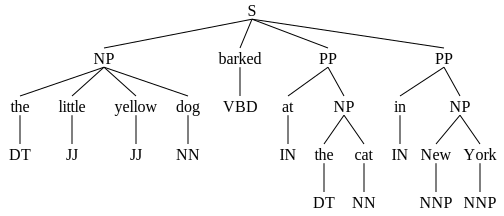

In [ ]:
#!pip install svgling
import svgling
sentence = [("the", "DT"), ("little", "JJ"), ("yellow", "JJ"),("dog", "NN"),\
          ("barked", "VBD"), ("at", "IN"), ("the", "DT"), ("cat", "NN"), \
          ("in", "IN"), ("New", "NNP"), ("York", "NNP")]

grammar = \
r"""
  NP: {<DT>?<JJ>*<NN.*>+}      # Chunk sequences of DT, JJ, NN as well as NN.*
  PP: {<IN><NP>}               # Chunk prepositions followed by NP
"""

cp = nltk.RegexpParser(grammar)
result = cp.parse(sentence)
svgling.draw_tree(result)